In [20]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import Estimate

from LimitedCommitmentModel import LimitedCommitmentModelClass

# plot style
linestyles = ['-','--','-.',':',':']
markers = ['o','s','D','*','P']
linewidth = 2
font_size = 17
font = {'size':font_size}
matplotlib.rc('font', **font)


plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

SAVE = False

# c++ settings

do_compile = True
threads = 7

# problem: Mange perioder, værdien af HK i første periode er meget lavt, hvis vi ikke har HK, måske ændre til type? Type med højt return og type med lavt return

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


# Solve the model

In [21]:
# compile c++ files
#T = 20
##sigma_HK = 0.5
#sigma_HK_init = 1.0
#sigma_love = 0.031
specs = {}
for T in [10 , 20 ]:
    for sigma_HK in [0.1,0.5, 1.0]:
        for sigma_HK_init in [0.1, 0.5, 1.0]:
            for sigma_love in [0.031 , 0.0001]:
                #print(T)
                #specs = specs | {f'model NC, NO_HK_T{T}_sHK{sigma_HK}_initHK{sigma_HK_init}_SL{sigma_love}':{'latexname':'limited', 'par':{ 'T':T, 'sigma_HK':sigma_HK, 'sigma_HK_init': sigma_HK_init, 'sigma_love': sigma_love, 'do_HK': False, 'threads':threads,'bargaining':2}}}
                specs.update({f'model_FC_NO_HK_T{T}_sHK{sigma_HK}_initHK{sigma_HK_init}_SL{sigma_love}':{'latexname':'limited', 'par':{ 'T':T, 'sigma_K':sigma_HK, 'sigma_K_init': sigma_HK_init, 'sigma_love': sigma_love, 'do_HK': False, 'threads':threads,'bargaining':0}}})
                specs.update({f'model_LC_NO_HK_T{T}_sHK{sigma_HK}_initHK{sigma_HK_init}_SL{sigma_love}':{'latexname':'limited', 'par':{ 'T':T, 'sigma_K':sigma_HK, 'sigma_K_init': sigma_HK_init, 'sigma_love': sigma_love, 'do_HK': False, 'threads':threads,'bargaining':1}}})
                specs.update({f'model_NC_NO_HK_T{T}_sHK{sigma_HK}_initHK{sigma_HK_init}_SL{sigma_love}':{'latexname':'limited', 'par':{ 'T':T, 'sigma_K':sigma_HK, 'sigma_K_init': sigma_HK_init, 'sigma_love': sigma_love, 'do_HK': False, 'threads':threads,'bargaining':2}}})
print(specs)


#sigma_HK_init er stort og T er mindre, det burde give, at initialt betyder noget ved FC, ellers er init_HK er kun en periode ud af 20 --> påvirker ikke barganing

{'model_FC_NO_HK_T10_sHK0.1_initHK0.1_SL0.031': {'latexname': 'limited', 'par': {'T': 10, 'sigma_K': 0.1, 'sigma_K_init': 0.1, 'sigma_love': 0.031, 'do_HK': False, 'threads': 7, 'bargaining': 0}}, 'model_LC_NO_HK_T10_sHK0.1_initHK0.1_SL0.031': {'latexname': 'limited', 'par': {'T': 10, 'sigma_K': 0.1, 'sigma_K_init': 0.1, 'sigma_love': 0.031, 'do_HK': False, 'threads': 7, 'bargaining': 1}}, 'model_NC_NO_HK_T10_sHK0.1_initHK0.1_SL0.031': {'latexname': 'limited', 'par': {'T': 10, 'sigma_K': 0.1, 'sigma_K_init': 0.1, 'sigma_love': 0.031, 'do_HK': False, 'threads': 7, 'bargaining': 2}}, 'model_FC_NO_HK_T10_sHK0.1_initHK0.1_SL0.0001': {'latexname': 'limited', 'par': {'T': 10, 'sigma_K': 0.1, 'sigma_K_init': 0.1, 'sigma_love': 0.0001, 'do_HK': False, 'threads': 7, 'bargaining': 0}}, 'model_LC_NO_HK_T10_sHK0.1_initHK0.1_SL0.0001': {'latexname': 'limited', 'par': {'T': 10, 'sigma_K': 0.1, 'sigma_K_init': 0.1, 'sigma_love': 0.0001, 'do_HK': False, 'threads': 7, 'bargaining': 1}}, 'model_NC_NO_HK

In [9]:

specs = {}
T = 10
sigma_love = 0.031
sigma_HK = 0.1
sigma_HK_init = 0.1
#specs.update({f'model_FC_NO_HK_T{T}_sHK{sigma_HK}_initHK{sigma_HK_init}_SL{sigma_love}':{'latexname':'limited', 'par':{ 'T':T, 'sigma_K':sigma_HK, 'sigma_K_init': sigma_HK_init, 'sigma_love': sigma_love, 'do_HK': False, 'threads':threads,'bargaining':0}}})
#specs.update({f'model_LC_NO_HK_T{T}_sHK{sigma_HK}_initHK{sigma_HK_init}_SL{sigma_love}':{'latexname':'limited', 'par':{ 'T':T, 'sigma_K':sigma_HK, 'sigma_K_init': sigma_HK_init, 'sigma_love': sigma_love, 'do_HK': False, 'threads':threads,'bargaining':1}}})
#specs.update({f'model_NC_NO_HK_T{T}_sHK{sigma_HK}_initHK{sigma_HK_init}_SL{sigma_love}':{'latexname':'limited', 'par':{ 'T':T, 'sigma_K':sigma_HK, 'sigma_K_init': sigma_HK_init, 'sigma_love': sigma_love, 'do_HK': False, 'threads':threads,'bargaining':2}}})

specs.update({f'model_FC':{'latexname':'limited', 'par':{ 'T':T, 'sigma_K':sigma_HK, 'sigma_K_init': sigma_HK_init, 'sigma_love': sigma_love, 'do_HK': False, 'threads':threads,'bargaining':0}}})
specs.update({f'model_LC':{'latexname':'limited', 'par':{ 'T':T, 'sigma_K':sigma_HK, 'sigma_K_init': sigma_HK_init, 'sigma_love': sigma_love, 'do_HK': False, 'threads':threads,'bargaining':1}}})
specs.update({f'model_NC':{'latexname':'limited', 'par':{ 'T':T, 'sigma_K':sigma_HK, 'sigma_K_init': sigma_HK_init, 'sigma_love': sigma_love, 'do_HK': False, 'threads':threads,'bargaining':2}}})
print(specs)



# solve different models
models = {}
for m,(name,spec) in enumerate(specs.items()):
    print(f'{name} loading...',end='')
    
    # setup model
    models[name] = LimitedCommitmentModelClass(name=name,par=spec['par'])
    models[name].spec = spec

    compile_now = True if do_compile & (m==0) else False
    models[name].link_to_cpp(force_compile=compile_now)
    
    print(' solving...')
    %time models[name].solve() 

    #Save the data 
    T = models[name].par.T
    print(' saving...')
    models[name].sim.init_love[:] = 0.2
    models[name].sim.init_A[:] = 0.0
    np.random.seed(models[name].par.seed)
    data1 = Estimate.create_data_new(models[name],start_p = 1, end_p = T-1, to_xl = True, name_xl = name)
        
    print(f'couple {np.mean(models[name].sim.couple,0)}')
    print(f'power {np.mean(models[name].sim.power,0)}')
    print(f'max_kw {np.max(models[name].sim.Kw,0)}')
    print(f' mean Kw {np.mean(models[name].sim.Kw,0)}')
    print(f' mean labor w {np.mean(models[name].sim.labor_w,0)}')
    print(f' mean A {np.nanmean(models[name].sim.A,0)}')

    #data1 = Estimate.create_data_new(model,start_p = 1, end_p = 2, to_xl = True, name_xl = name)

{'model_NC': {'latexname': 'limited', 'par': {'T': 10, 'sigma_K': 0.1, 'sigma_K_init': 0.1, 'sigma_love': 0.031, 'do_HK': False, 'threads': 7, 'bargaining': 2}}}
model_NC loading... solving...
CPU times: total: 19min 38s
Wall time: 5min 21s
 saving...
couple [1.         1.         1.         1.         1.         1.
 1.         0.9998     0.99866667 0.99263333]
power [0.5        0.5        0.5        0.4999989  0.49982842 0.49874748
 0.49567616 0.49032608 0.48164054 0.45893999]
max_kw [1.99991622 1.99241943 2.90897843 3.76047495 4.55808104 4.9850127
 5.69764106 6.44182034 7.28328528 7.34640715]
 mean Kw [1.00443607 1.32017561 1.9213288  2.4801382  2.99940118 3.47575682
 3.91810473 4.3229865  4.68351786 5.00160304]
 mean labor w [0.74049792 0.70961494 0.69337357 0.69001979 0.67212841 0.65713749
 0.6493386  0.65198243 0.64235367 0.62475972]
 mean A [0.32220148 0.23846995 0.18162215 0.3364366  0.43496141 0.46284936
 0.52069196 0.70701051 0.73014244 0.18993327]


In [17]:
model1 = models['model_NC']
print(model1.par.T)
print(model1.par.bargaining)
print(np.max(model1.sim.couple,0))
print(np.max(model1.sim.Kw,0))
print(np.mean(model1.sim.Kw,0))
print(np.mean(model1.sim.labor_w,0))
print(np.nanmean(model1.sim.A,0))

print(np.nanmean(model1.sim.power,0))

#model2 = models['model FC, NO_HK_T3_sHK0.1_initHK0.1_SL0.031']
#print(model2.par.T)
#print(model2.par.bargaining)
#print(model2.par.sigma_K_init)
#print(model2.par.sigma_HK)
#print(model2.par.sigma_love)
#print(np.max(model2.sim.Kw,0))
#print(np.mean(model2.sim.Kw,0))
#print(np.mean(model2.sim.labor_w,0))
#print(np.mean(model2.sim.A,0))


#model1 = models['model FC, NO_HK_T3_sHK0.1_initHK1.0_SL0.0001']
#print(model1.par.T)
#print(model1.par.bargaining)
#print(model1.par.sigma_K_init)
#print(model1.par.sigma_HK)
#print(model1.par.sigma_love)
#print(np.max(model1.sim.Kw,0))
#print(np.mean(model1.sim.Kw,0))
#print(np.mean(model1.sim.labor_w,0))
#print(np.mean(model1.sim.A,0))

#model2 = models['model FC, NO_HK_T3_sHK0.1_initHK0.1_SL0.0001']
#print(model2.par.T)
#print(model2.par.bargaining)
#print(model2.par.sigma_K_init)
#print(model2.par.sigma_HK)
#print(model2.par.sigma_love)
#print(np.max(model2.sim.Kw,0))
#print(np.mean(model2.sim.Kw,0))
#print(np.mean(model2.sim.labor_w,0))
#print(np.mean(model2.sim.A,0))

10
2
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.99991622 1.99241943 2.90897843 3.76047495 4.55808104 4.9850127
 5.69764106 6.44182034 7.28328528 7.34640715]
[1.00443607 1.32017561 1.9213288  2.4801382  2.99940118 3.47575682
 3.91810473 4.3229865  4.68351786 5.00160304]
[0.74049792 0.70961494 0.69337357 0.69001979 0.67212841 0.65713749
 0.6493386  0.65198243 0.64235367 0.62475972]
[0.32220148 0.23846995 0.18162215 0.3364366  0.43496141 0.46284936
 0.52069196 0.70701051 0.73014244 0.18993327]
[0.5        0.5        0.5        0.4999989  0.49982842 0.49874748
 0.49567616 0.49032608 0.48164054 0.45893999]


In [18]:


#model = models['model FC, NO_HK ']
#model.sim.init_love[:] =0.2
##model.simulate()
#print('HK')*
#print(f'Couple {np.mean(model.sim.couple,0)}')

#print(f'Laborw {np.mean(model.sim.labor_w,0)}')
#print(f'Laborm {np.mean(model.sim.labor_m,0)}')
#print(f'Consumption W {np.mean(model.sim.cons_w,0)}')
#print(f'Consumption M {np.mean(model.sim.cons_m,0)}')
#print(f'Asset {np.nanmean(model.sim.A,0)}')
#print(f'HKw {np.mean(model.sim.Kw,0)}')
#print(f'HKm {np.mean(model.sim.Km,0)}')
#temp = model.sim.power
#I = model.sim.couple<1
#nan = np.zeros(I.shape)
#nan[I] = np.nan
#temp = np.nanmean(temp + nan,axis=0)
#print(f'Power {temp}')


model = models[f'model_NC']
#model.sim.init_love[:] =0.1
#model.sim.init_A[:] = 6.0
#model.simulate()
print('NO hk')

i = 4
#note kvinden tjenner fx meget mere i en periode: 
    #højere barganing --> hun arbjeder mnindre , mand mere
    # højere indkomst --> hun og hendes mand arbjeder mindre. Dermed skal X5 påvirkes også her (INDKOMSTEFFEKT)
print(f'Person i, init Kw {model.sim.init_Kw[i]}')
print(f'Person i, init Km {model.sim.init_Km[i]}')
print(f'Person i, power {model.sim.power[i,:]}')
print(f'Person i, Kw {model.sim.Kw[i]}')
print(f'Person i, Km {model.sim.Km[i]}')
print(f'Person i, Laborw {model.sim.labor_w[i]}')
print(f'Person i, Laborm {model.sim.labor_m[i]}')
print(f'Person i, A {model.sim.A[i]}')
print(f'Person i, Aw {model.sim.Aw[i]}')
print(f'Person i, Am {model.sim.Am[i]}')
print(f'Person i, consw {model.sim.cons_w[i]}')
print(f'Couple {np.mean(model.sim.couple,0)}')

print(f'Laborw {np.mean(model.sim.labor_w,0)}')
print(f'Laborm {np.mean(model.sim.labor_m,0)}')
print(f'Consumption W {np.mean(model.sim.cons_w,0)}')
print(f'Consumption M {np.mean(model.sim.cons_m,0)}')
print(f'Asset {np.nanmean(model.sim.A,0)}')
print(f'Asset min {np.nanmin(model.sim.A,0)}')
print(f'Asset max {np.nanmax(model.sim.A,0)}')
print(f'Asset W {np.nanmean(model.sim.Aw,0)}')
print(f'Asset M {np.nanmean(model.sim.Am,0)}')
print(f'HKw {np.mean(model.sim.Kw,0)}')
print(f'HKm {np.mean(model.sim.Km,0)}')
print(f'HKw max {np.max(model.sim.Kw,0)}')
print(f'HKm max {np.max(model.sim.Km,0)}')
print(f'HKw min {np.min(model.sim.Kw,0)}')
print(f'HKm min {np.min(model.sim.Km,0)}')
print(f'Power mean {np.mean(model.sim.power,0)}')
print(f'Power min {np.min(model.sim.power,0)}')
print(f'Power max {np.max(model.sim.power,0)}')




NO hk
Person i, init Kw 0.45791739886856586
Person i, init Km 0.33128764654267195
Person i, power [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Person i, Kw [0.4579174  1.28646782 1.65898223 2.32744239 2.90243927 3.44832075
 4.04335629 4.17976285 4.12872708 4.51381072]
Person i, Km [0.33128765 1.05431284 1.99010557 2.29184822 3.10353882 3.27131261
 3.94009183 3.91065004 4.55178137 4.61843819]
Person i, Laborw [0.74959476 0.72796016 0.69173743 0.69394701 0.6740311  0.65975719
 0.65844718 0.64324733 0.63950849 0.64656152]
Person i, Laborm [0.75128125 0.73986933 0.73944511 0.72724435 0.72286552 0.70191772
 0.69633401 0.68912992 0.69209999 0.66075512]
Person i, A [0.05611573 0.10923465 0.12028468 0.19791071 0.34443083 0.24458821
 0.35385047 0.22074853 0.23980603 0.        ]
Person i, Aw [0.02805786 0.05461732 0.06014234 0.09895535 0.17221541 0.1222941
 0.17692524 0.11037426 0.11990301 0.        ]
Person i, Am [0.02805786 0.05461732 0.06014234 0.09895535 0.17221541 0.1222941
 0.17692524 0.11037

0.17005992887045385
0.40462567522381887
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
0.12050720705932783
1.5752877570614197
[0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.41312005 0.49270751]
power mean [0.5        0.5        0.5        0.4999989  0.49982842 0.49874748
 0.49567616 0.49032608 0.48164054 0.45893999]
power min [ 0.5         0.5         0.5         0.48304133  0.41603964  0.34852693
  0.33474968 -1.         -1.         -1.        ]
power max [0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.52638632]
Kw [1.99991622 1.99241943 2.90897843 3.76047495 4.55808104 4.9850127
 5.69764106 6.44182034 7.28328528 7.34640715]
[0. 0. 0. ... 0. 0. 0.]
[[8.95428705e-02 1.06618944e-03]
 [1.06618944e-03 8.88323720e-05]]
[[ 8.95428705e-02 -3.82167146e-06]
 [-3.82167146e-06  5.31870575e-05]]
[[ 6.31062361e-02 -2.94450541e-04]
 [-2.94450541e-04  8.88323720e-05]]
[0. 0. 1. ... 0. 0. 1.]


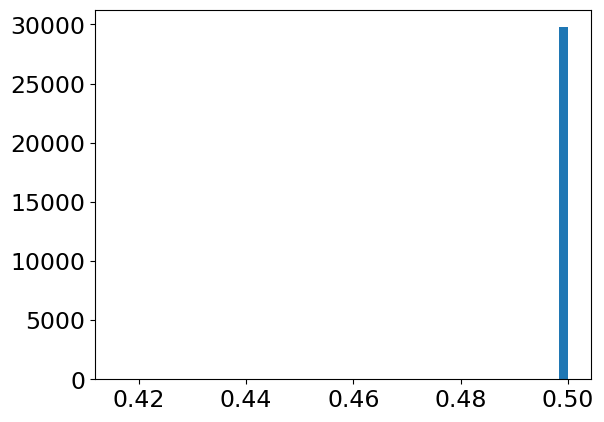

[[ 5.71333464e-06 -8.32234143e-06]
 [-8.32234143e-06  2.50007196e-01]]


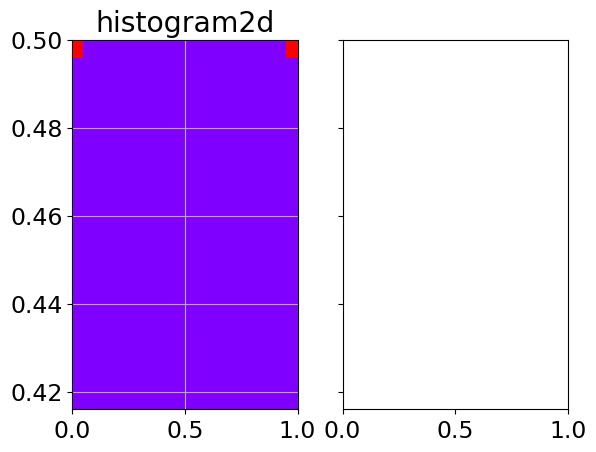

In [19]:

i = 10
print(model.sim.init_Kw[i])
print(model.sim.init_Km[i])
print(model.sim.power[i,:])



i = 1
print(model.sim.init_Kw[i])
print(model.sim.init_Km[i])
print(model.sim.power[i,:])



t = 4
print(f'power mean {np.mean(model.sim.power,0)}')
print(f'power min {np.min(model.sim.power,0)}')
print(f'power max {np.max(model.sim.power,0)}')
print(f'Kw {np.max(model.sim.Kw,0)}')


I = model.sim.couple[:,t]<1.0
nan = np.zeros(I.shape)
nan[I] = np.nan
print(nan)

init_barg = model.sim.init_Kw > model.sim.init_Km
init_barg = init_barg+nan

sim_power= model.sim.power[:,t]
sim_power= sim_power+ nan



print(np.cov(model.sim.Kw[:,t],model.sim.labor_w[:,t]))

print(np.cov(model.sim.Kw[:,t],model.sim.labor_w[:,t-1]))

print(np.cov(model.sim.Kw[:,t-1],model.sim.labor_w[:,t]))


print(init_barg)
plt.hist(model.sim.power[:,t], bins = 50 )
plt.show()

print(np.cov(model.sim.power[:,t],init_barg))
H, yedges, xedges = np.histogram2d(model.sim.power[:,t], init_barg, bins=20)
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.pcolormesh(xedges, yedges, H, cmap='rainbow')
ax1.set_title('histogram2d')
ax1.grid()
plt.show()

0.5555555555555554
[-2.85146878 -2.8293574  -2.80732892 -2.78505683 -2.76253652 -2.73978484
 -2.71702678 -2.69365944 -2.66993741 -2.64609589 -2.62172442 -2.59665562
 -2.57094216 -2.54467962 -2.51743447 -2.48909431 -2.45930191 -2.42812794
 -2.3939838  -2.35491607]
[-2.90307098 -2.88500827 -2.86490396 -2.84417395 -2.82391397 -2.80301135
 -2.78103525 -2.75929389 -2.73692697 -2.71458581 -2.69105187 -2.66737712
 -2.64313735 -2.61760883 -2.59165123 -2.56468106 -2.53577219 -2.50457677
 -2.47043008 -2.43138616]
[0.76885446 0.76881292 0.76097581 0.7575026  0.74680043 0.74560764
 0.73591836 0.73286597 0.72582701 0.71545135 0.71096352 0.70508622
 0.69638549 0.69319978 0.68538779 0.67820938 0.67474804 0.67466802
 0.6747332  0.67497762]
[0.55255509 0.54553905 0.54097321 0.53493507 0.52883955 0.52353004
 0.52144187 0.51471906 0.50863997 0.50570782 0.50200715 0.4966921
 0.49204947 0.48938168 0.483267   0.4777202  0.47173268 0.4717377
 0.47195856 0.47171043]
[0.86830856 0.85519689 0.84967157 0.8430641

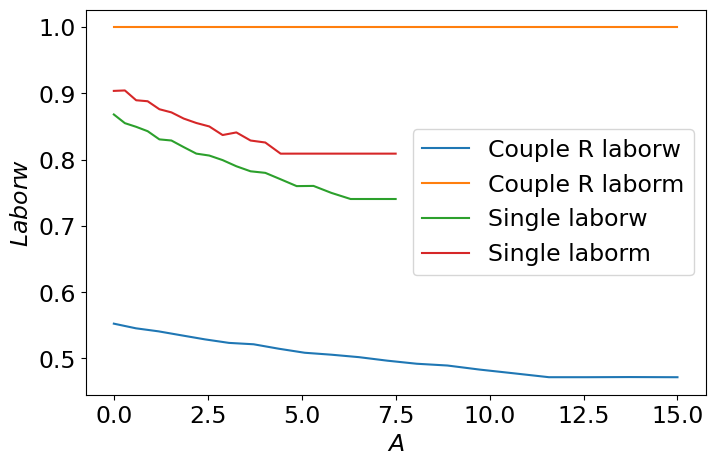

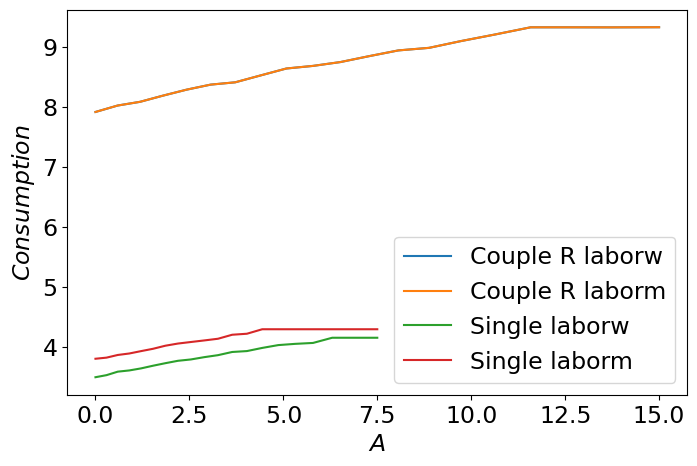

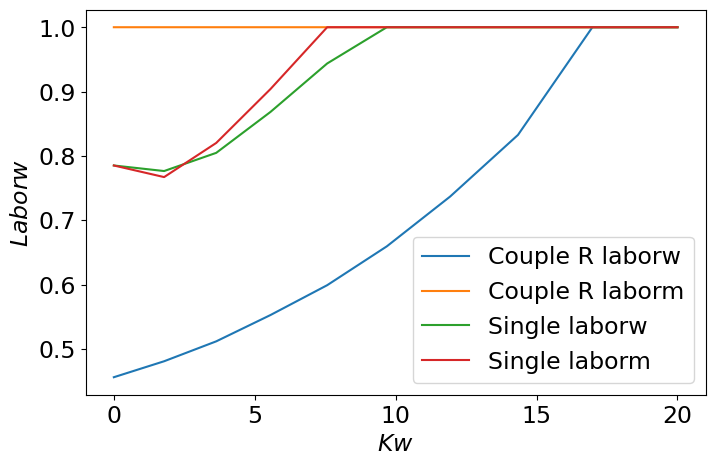

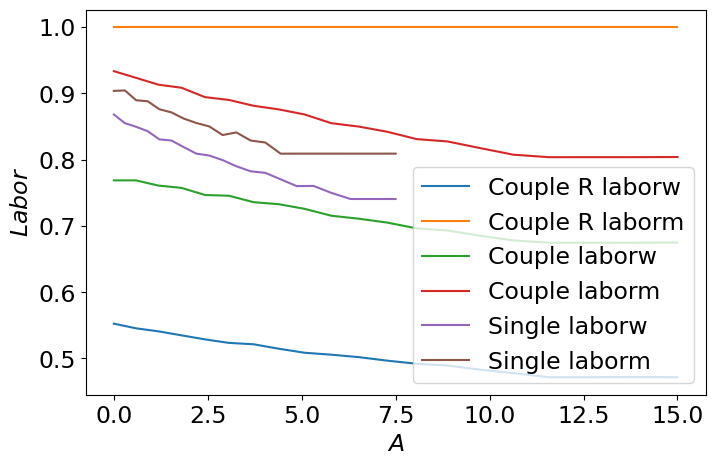

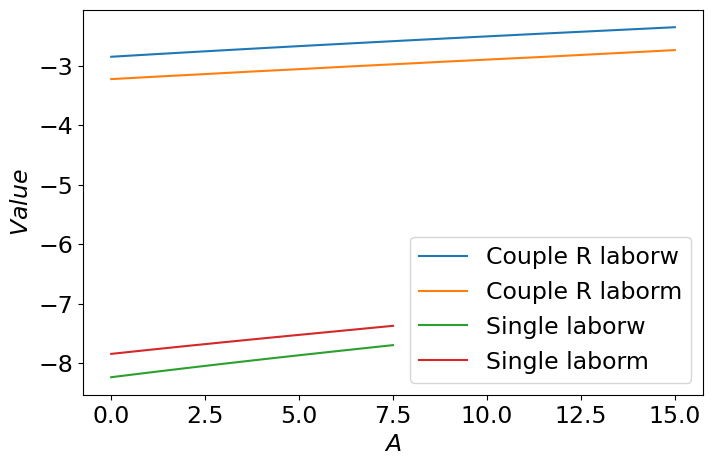

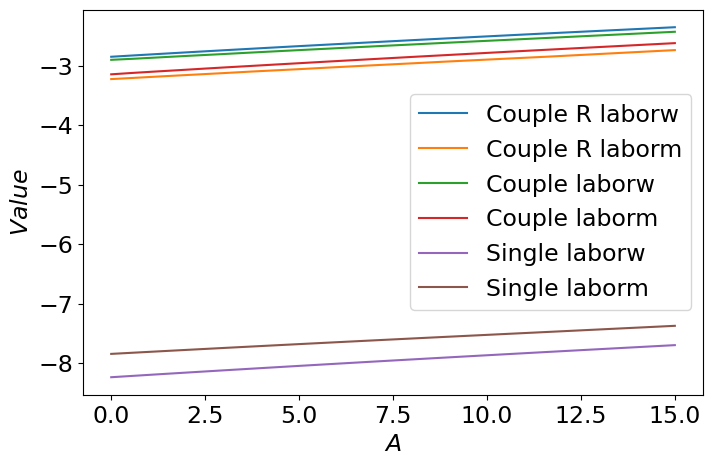

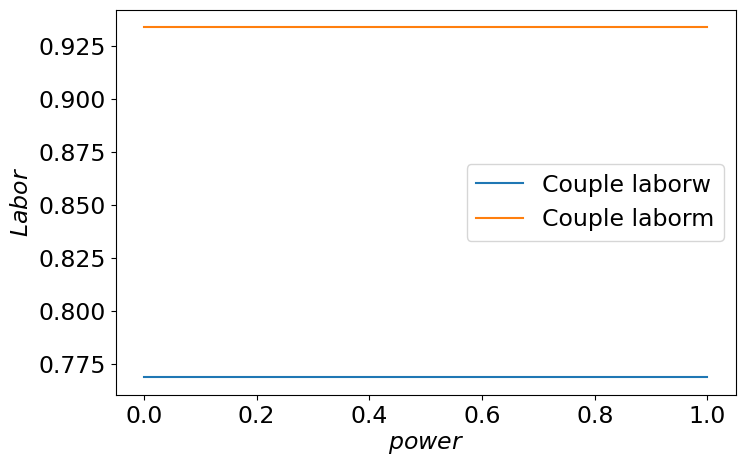

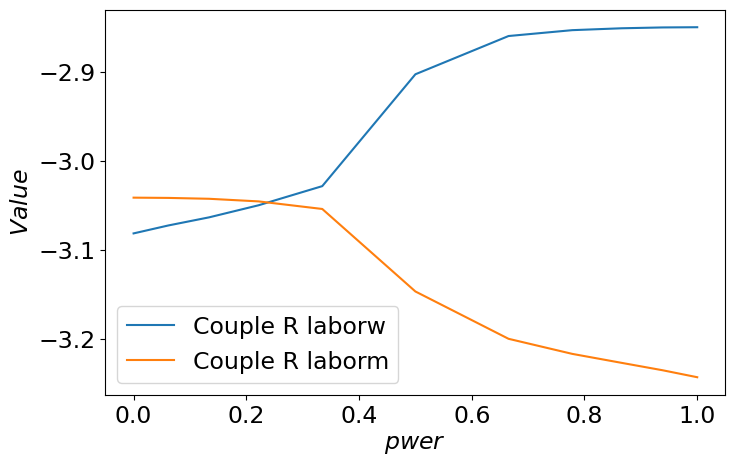

-8.239017373830249
-7.846750721654061


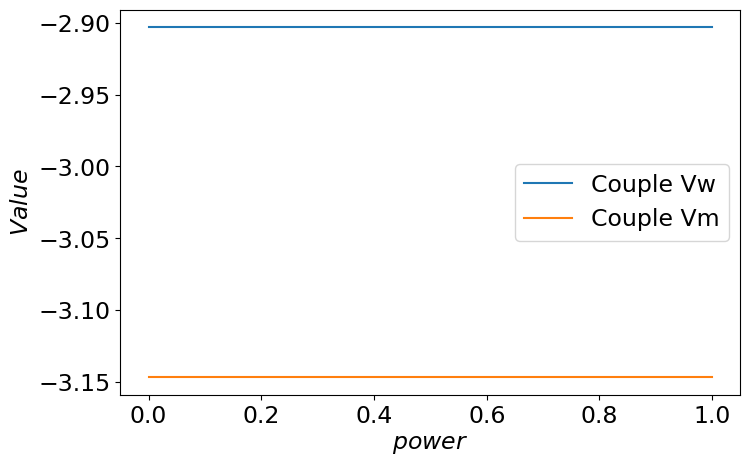

In [6]:
i_P = 8
#i_P = 8
i_A = 0
i_L = 7
i_t = 1
i_HKw = 3
i_HKm = 3
t = i_t


#sol = models['model 2'].sol
#par = models['model 2'].par


#print(sol.labor_w_couple[t,i_P,i_L,:,i_HKw,i_HKm])

#print(sol.labor_w_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm])

#print(sol.labor_w_single[t,:,i_HKm])


sol = models['model_NC'].sol
par = models['model_NC'].par
print(par.grid_love[i_L])

print(sol.Vw_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm])

print(sol.Vw_couple[t,i_P,i_L,:,i_HKw,i_HKm])

print(sol.labor_w_couple[t,i_P,i_L,:,i_HKw,i_HKm])

print(sol.labor_w_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm])

print(sol.labor_w_single[t,:,i_HKw])
print(sol.labor_m_single[t,:,i_HKw])


print(sol.Vw_single[t,:,i_HKw])




fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_A,sol.labor_w_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborw')
ax.plot(par.grid_A,sol.labor_m_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborm')
ax.plot(par.grid_Aw,sol.labor_w_single[t,:,i_HKw], label = 'Single laborw')
ax.plot(par.grid_Am,sol.labor_m_single[t,:,i_HKm], label = 'Single laborm')                      
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$Laborw$")
plt.legend()
plt.show()


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_A,sol.cons_w_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborw')
ax.plot(par.grid_A,sol.cons_m_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborm')
ax.plot(par.grid_Aw,sol.cons_w_single[t,:,i_HKw], label = 'Single laborw')
ax.plot(par.grid_Am,sol.cons_m_single[t,:,i_HKm], label = 'Single laborm')                      
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$Consumption$")
plt.legend()
plt.show()




fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_K,sol.labor_w_remain_couple[t,i_P,i_L,i_A,:,i_HKm], label = 'Couple R laborw')
ax.plot(par.grid_K,sol.labor_m_remain_couple[t,i_P,i_L,i_A,:,i_HKm], label = 'Couple R laborm')
ax.plot(par.grid_K,sol.labor_w_single[t,i_A,:], label = 'Single laborw')
ax.plot(par.grid_K,sol.labor_m_single[t,i_A,:], label = 'Single laborm')                      
ax.set_xlabel(f"$Kw$")
ax.set_ylabel(f"$Laborw$")
plt.legend()
plt.show()



fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_A,sol.labor_w_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborw')
ax.plot(par.grid_A,sol.labor_m_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborm')
ax.plot(par.grid_A,sol.labor_w_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple laborw')
ax.plot(par.grid_A,sol.labor_m_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple laborm')
ax.plot(par.grid_Aw,sol.labor_w_single[t,:,i_HKw], label = 'Single laborw')
ax.plot(par.grid_Am,sol.labor_m_single[t,:,i_HKm], label = 'Single laborm')                      
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$Labor$")
plt.legend()
plt.show()


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_A,sol.Vw_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborw')
ax.plot(par.grid_A,sol.Vm_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborm')
ax.plot(par.grid_Aw,sol.Vw_single[t,:,i_HKw], label = 'Single laborw')
ax.plot(par.grid_Am,sol.Vm_single[t,:,i_HKm], label = 'Single laborm')                      
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$Value$")
plt.legend()
plt.show()


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_A,sol.Vw_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborw')
ax.plot(par.grid_A,sol.Vm_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborm')
ax.plot(par.grid_A,sol.Vw_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple laborw')
ax.plot(par.grid_A,sol.Vm_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple laborm')
ax.plot(par.grid_A,sol.Vw_single[t,:,i_HKw], label = 'Single laborw')
ax.plot(par.grid_A,sol.Vm_single[t,:,i_HKm], label = 'Single laborm')                      
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$Value$")
plt.legend()
plt.show()



fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_power,sol.labor_w_couple[t,:,i_L,i_A,i_HKw,i_HKm], label = 'Couple laborw')
ax.plot(par.grid_power,sol.labor_m_couple[t,:,i_L,i_A,i_HKw,i_HKm], label = 'Couple laborm')
ax.set_xlabel(f"$power$")
ax.set_ylabel(f"$Labor$")
plt.legend()
plt.show()

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_power,sol.Vw_remain_couple[t,:,i_L,i_A,i_HKw,i_HKm], label = 'Couple R laborw')
ax.plot(par.grid_power,sol.Vm_remain_couple[t,:,i_L,i_A,i_HKw,i_HKm], label = 'Couple R laborm')
ax.set_xlabel(f"$pwer$")
ax.set_ylabel(f"$Value$")
plt.legend()
plt.show()

print(sol.Vw_single[t,i_A,i_HKw])
print(sol.Vm_single[t,i_A,i_HKm])
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_power,sol.Vw_couple[t,:,i_L,i_A,i_HKw,i_HKm], label = 'Couple Vw')
ax.plot(par.grid_power,sol.Vm_couple[t,:,i_L,i_A,i_HKw,i_HKm], label = 'Couple Vm')                   
ax.set_xlabel(f"$power$")
ax.set_ylabel(f"$Value$")
plt.legend()
plt.show()




# Estimate the model

In [ ]:
#Save the data 
model = models['model NC, NO_HK ']
model.sim.init_love[:] =0.1
model.sim.init_A[:] = 6.0
np.random.seed(model.par.seed)
data1 = Estimate.create_data_new(model,start_p = 9, end_p = 19, to_xl = True, name_xl = 'simulated_data_NC_NO_HK4')


In [ ]:
#Save the data 
#model = models['model LC, NO_HK ']
#model.sim.init_love[:] =0.1
#model.sim.init_A[:] = 6.0
#np.random.seed(model.par.seed)
#data1 = Estimate.create_data_new(model,start_p = 2, end_p = 19, to_xl = True, name_xl = 'simulated_data_LC_NO_HK2')


model = models['model LC, HK ']
model.sim.init_love[:] =0.3
model.sim.init_A[:] = 6.0
np.random.seed(model.par.seed)
data2 = Estimate.create_data_new(model,start_p = 2, end_p = 19, to_xl = True, name_xl = 'simulated_data_LC_HK')

#model = models['model NC, NO_HK ']
#model.sim.init_love[:] =0.1
#model.sim.init_A[:] = 6.0
#np.random.seed(model.par.seed)
#data1 = Estimate.create_data_new(model,start_p = 2, end_p = 19, to_xl = True, name_xl = 'simulated_data_NC_NO_HK2')


model = models['model NC, HK ']
model.sim.init_love[:] =0.3
model.sim.init_A[:] = 6.0
np.random.seed(model.par.seed)
data2 = Estimate.create_data_new(model,start_p = 2, end_p = 19, to_xl = True, name_xl = 'simulated_data_NC_HK')

#Save the data 
#model = models['model FC, NO_HK ']
#model.sim.init_love[:] =0.1
#model.sim.init_A[:] = 6.0
#np.random.seed(model.par.seed)
#data1 = Estimate.create_data_new(model,start_p = 2, end_p = 19, to_xl = True, name_xl = 'simulated_data_FC_NO_HK2')


model = models['model FC, HK ']
model.sim.init_love[:] =0.3
model.sim.init_A[:] = 6.0
np.random.seed(model.par.seed)
data2 = Estimate.create_data_new(model,start_p = 2, end_p = 19, to_xl = True, name_xl = 'simulated_data_FC_HK')


In [ ]:

#Estimate the model one time
data_reg = Estimate.aux_est(data2,print_reg=True)
data_reg, Wald_FC, Wald_NC = Estimate.main_est(data_reg,print_reg=True) 